# 基于视觉语言大模型的零样本图像文本检索

In [1]:
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import faiss

In [2]:
DEVICE = "cuda:1"

## 计算图片文本检索召回率

In [3]:
def image2text(logits_per_image):
  image_cnt = logits_per_image.shape[0]
  ranks = np.zeros(image_cnt)
  indices = torch.argsort(logits_per_image, dim=1, descending=True)
  for idx in range(image_cnt):
    rank = 1e20
    for i in range(5 * idx, 5 * idx + 5):
      tmp = torch.where(indices[idx] == i)[0][0]
      if tmp < rank:
        rank = tmp
    ranks[idx] = rank
  r1 = len(np.where(ranks < 1)[0])
  r5 = len(np.where(ranks < 5)[0])
  r10 = len(np.where(ranks < 10)[0])
  return r1, r5, r10

In [4]:
def text2image(logits_per_text):
  text_cnt = logits_per_text.shape[0]
  ranks = np.zeros(text_cnt)
  indices = torch.argsort(logits_per_text, dim=1, descending=True)
  for idx in range(text_cnt):
    ranks[idx] = torch.where(indices[idx] == idx // 5)[0][0]
  r1 = len(np.where(ranks < 1)[0])
  r5 = len(np.where(ranks < 5)[0])
  r10 = len(np.where(ranks < 10)[0])
  return r1, r5, r10

## 加载预训练模型

In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(DEVICE)
model.eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

/home/yirguo/data/conda_env/cross_modal_homework/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 加载数据集

In [6]:
dataset = load_dataset("nlphuji/flickr30k")
dataset = dataset["test"]

In [7]:
train_set = dataset.filter(lambda example: example['split'] == 'train')
val_set = dataset.filter(lambda example: example['split'] == 'val')
test_set = dataset.filter(lambda example: example['split'] == 'test')

In [8]:
i2t_r1 = 0
i2t_r5 = 0
i2t_r10 = 0

t2i_r1 = 0
t2i_r5 = 0
t2i_r10 = 0

batch_size = 256
max_len = 77

## 统计图片文本检索召回率

In [9]:
for idx in tqdm(range(0, len(test_set), batch_size)):
  captions = test_set[idx : idx + batch_size]["caption"]
  captions = [caption[:max_len] for nested_caption in captions for caption in nested_caption]
  images = test_set[idx : idx + batch_size]["image"]
  inputs = processor(text=captions, images=images, return_tensors="pt", padding=True)
  inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs)
  r1, r5, r10 = image2text(outputs.logits_per_image)
  i2t_r1 += r1
  i2t_r5 += r5
  i2t_r10 += r10
  r1, r5, r10 = text2image(outputs.logits_per_text)
  t2i_r1 += r1
  t2i_r5 += r5
  t2i_r10 += r10

100%|██████████| 4/4 [00:49<00:00, 12.37s/it]


In [10]:
i2t_r1 = 100.0 * i2t_r1 / len(test_set)
i2t_r5 = 100.0 * i2t_r5 / len(test_set)
i2t_r10 = 100.0 * i2t_r10 / len(test_set)

t2i_r1 = 100.0 * t2i_r1 / len(test_set) / 5
t2i_r5 = 100.0 * t2i_r5 / len(test_set) / 5
t2i_r10 = 100.0 * t2i_r10 / len(test_set) / 5

In [11]:
print("Image to Text:")
print("R @ 1:", i2t_r1)
print("R @ 5:", i2t_r5)
print("R @ 10:", i2t_r10)

print("Text to Image:")
print("R @ 1:", t2i_r1)
print("R @ 5:", t2i_r5)
print("R @ 10:", t2i_r10)

Image to Text:
R @ 1: 90.3
R @ 5: 98.9
R @ 10: 99.6
Text to Image:
R @ 1: 75.82000000000001
R @ 5: 93.36
R @ 10: 96.42


## 使用Flickr30k数据集构建向量数据库

In [9]:
vector_dim = 768
image_index = faiss.IndexFlatIP(vector_dim)
text_index = faiss.IndexFlatIP(vector_dim)

In [10]:
for idx in tqdm(range(0, len(dataset), batch_size)):
  captions = dataset[idx : idx + batch_size]["caption"]
  captions = [caption[:max_len] for nested_caption in captions for caption in nested_caption]
  images = dataset[idx : idx + batch_size]["image"]
  inputs = processor(text=captions, images=images, return_tensors="pt", padding=True)
  inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs)
  image_index.add(outputs.image_embeds.cpu().numpy())
  text_index.add(outputs.text_embeds.cpu().numpy())

  0%|          | 0/122 [00:00<?, ?it/s]

100%|██████████| 122/122 [25:02<00:00, 12.32s/it]


In [11]:
def encode_text(text):
  inputs = processor(text=text, return_tensors="pt", padding=True).to(DEVICE)
  with torch.no_grad():
    text_outputs = model.text_model(**inputs)
    text_embeds = text_outputs[1]
    text_embeds = model.text_projection(text_embeds)
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
  return text_embeds.cpu().numpy()

In [12]:
def encode_image(image):
  inputs = processor(images=image, return_tensors="pt", padding=True).to(DEVICE)
  with torch.no_grad():
    vision_outputs = model.vision_model(**inputs)
    image_embeds = vision_outputs[1]
    image_embeds = model.visual_projection(image_embeds)
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
  return image_embeds.cpu().numpy()

In [13]:
def search_image_by_text(text, k=5):
  text_embeds = encode_text(text)
  _, indices = image_index.search(text_embeds, k)
  return dataset[indices[0]]['image']

In [14]:
def search_text_by_image(image_path, k=5):
  image = Image.open(image_path)
  image.show()
  image_embeds = encode_image(image)
  _, indices = image_index.search(image_embeds, k)
  return dataset[indices[0]]['caption']

In [15]:
def display_images(images, cols=5):
    total_images = len(images)
    rows = total_images // cols + (1 if total_images % cols else 0)

    fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 4))
    fig.tight_layout(pad=3.0)
    if rows == 1:
        axs = [axs]

    for i, image in enumerate(images):
        ax = axs[i // cols][i % cols]
        ax.imshow(image)
        ax.axis('off')
        ax.set_frame_on(False)

    for i in range(total_images, rows * cols):
        axs[i // cols][i % cols].axis('off')
        axs[i // cols][i % cols].set_frame_on(False)

    plt.show()


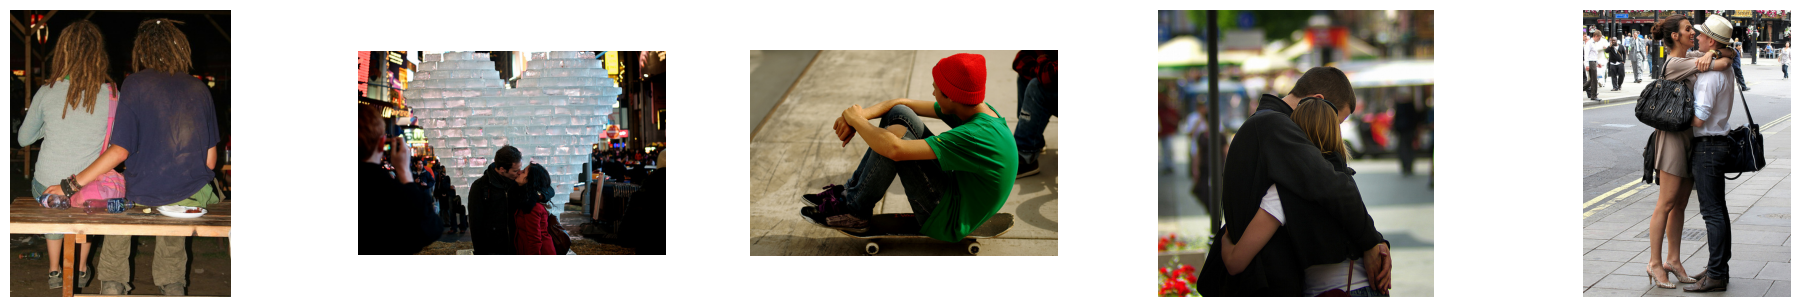

In [22]:
display_images(search_image_by_text("love"))

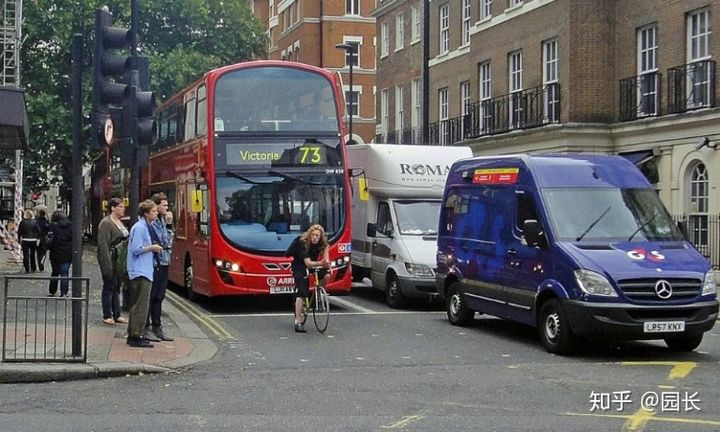

[['A woman in blue dress in crossing the street while a person in bright yellow is riding their bike down it.',
  'A woman in a blue and white polka dotted dress is crossing the street in a busy city.',
  'A city street scene with the backs of a woman crossing the street and a bicyclist.',
  'A busy women in black and white color dress is crossing the road.',
  'Pedestrians busy walking and shopping.'],
 ['Several people, one being a woman in a black dress, are outside, near a bike rack.',
  'A man chains his bike to a rack while a woman in black and red walks.',
  'Woman in black dress with red accessories is walking down the street.',
  'The woman wearing a red bow walks past a bicycle.',
  'Woman in a black dress walking on the street.'],
 ['A woman reading while sitting on a bench as traffic passes on the street behind her.',
  'A woman sits on a park bench as a scooter, car and bus drive by behind her.',
  'A city street with a metal bench occupied by a woman in black.',
  'A woma

In [23]:
search_text_by_image("image.jpg")